In [12]:
import tensorflow as tf
import random
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data

tf.reset_default_graph()
tf.set_random_seed(777)  # reproducibility

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# hyper parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

# 학습할 때와 다르게 테스트할 때는 1로 설정
keep_prob = tf.placeholder(tf.float32)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [13]:
# input place holders
X = tf.placeholder(tf.float32, [None, 784])
X_img = tf.reshape(X, [-1, 28, 28, 1])   # img 28x28x1 (black/white)
Y = tf.placeholder(tf.float32, [None, 10])

In [14]:
# L1 ImgIn shape=(?, 28, 28, 1)
W1 = tf.Variable(tf.random_normal([3, 3, 1, 32], stddev=0.01))
# Conv -> (?, 28, 28, 32)
# Pool -> (?, 14, 14, 32)
L1 = tf.nn.conv2d(X_img, W1, strides=[1, 1, 1, 1], padding='SAME')
print(L1)
L1 = tf.nn.relu(L1)
print(L1)
L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
print(L1)
L1 = tf.nn.dropout(L1, rate=keep_prob)
print(L1)

Tensor("Conv2D:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("Relu:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
Tensor("dropout/mul_1:0", shape=(?, 14, 14, 32), dtype=float32)


In [15]:
# L2 ImgIn shape=(?, 14, 14, 32)
W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.01))
# Conv -> (?, 14, 14, 64)
# Pool -> (?, 7, 7, 64)
L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
print(L2)
L2 = tf.nn.relu(L2)
print(L2)
L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
print(L2)
L2 = tf.nn.dropout(L2, keep_prob=keep_prob)
print(L2)

Tensor("Conv2D_1:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("Relu_1:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)
Tensor("dropout_1/mul_1:0", shape=(?, 7, 7, 64), dtype=float32)


In [16]:
# L3 ImgIn shape=(?, 7, 7, 64)
W3 = tf.Variable(tf.random_normal([3, 3, 64, 128], stddev=0.01))
# Conv -> (?, 7, 7, 128)
# Pool -> (?, 4, 4, 128)
# Reshape -> (?, 4 * 4 * 128) # Flatten them for FC
L3 = tf.nn.conv2d(L2, W3, strides=[1, 1, 1, 1], padding='SAME')
print(L3)
L3 = tf.nn.relu(L3)
print(L3)
L3 = tf.nn.max_pool(L3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
print(L3)
L3 = tf.nn.dropout(L3, rate=keep_prob)
print(L3)
L3_flat = tf.reshape(L3, [-1, 128 * 4 * 4])
print(L3)

Tensor("Conv2D_2:0", shape=(?, 7, 7, 128), dtype=float32)
Tensor("Relu_2:0", shape=(?, 7, 7, 128), dtype=float32)
Tensor("MaxPool_2:0", shape=(?, 4, 4, 128), dtype=float32)
Tensor("dropout_2/mul_1:0", shape=(?, 4, 4, 128), dtype=float32)
Tensor("dropout_2/mul_1:0", shape=(?, 4, 4, 128), dtype=float32)


In [17]:
# L4 FC 4x4x128 inputs -> 625 outputs
W4 = tf.get_variable("W4", shape=[128 * 4 * 4, 625], initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([625]))
L4 = tf.nn.relu(tf.matmul(L3_flat, W4) + b4)
print(L4)
L4 = tf.nn.dropout(L4, rate=keep_prob)
print(L4)

Tensor("Relu_3:0", shape=(?, 625), dtype=float32)
Tensor("dropout_3/mul_1:0", shape=(?, 625), dtype=float32)


In [18]:
# L5 Final FC 625 inputs -> 10 outputs
W5 = tf.get_variable("W5", shape=[625, 10], initializer=tf.contrib.layers.xavier_initializer())
b5 = tf.Variable(tf.random_normal([10]))
logits = tf.matmul(L4, W5) + b5
print(logits)

Tensor("add_1:0", shape=(?, 10), dtype=float32)


In [20]:
# define cost/loss & optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [21]:
# initialize
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [22]:
# train my model
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(mnist.train.num_examples / batch_size)

    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        feed_dict = {X: batch_xs, Y: batch_ys, keep_prob: 0.7}
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

Learning started. It takes sometime.
Epoch: 0001 cost = 0.773599622
Epoch: 0002 cost = 0.279511101
Epoch: 0003 cost = 0.204791427
Epoch: 0004 cost = 0.171918431
Epoch: 0005 cost = 0.157201430
Epoch: 0006 cost = 0.146468318
Epoch: 0007 cost = 0.138015665
Epoch: 0008 cost = 0.129929279
Epoch: 0009 cost = 0.123464354
Epoch: 0010 cost = 0.118836618
Epoch: 0011 cost = 0.116371491
Epoch: 0012 cost = 0.111011962
Epoch: 0013 cost = 0.111066220
Epoch: 0014 cost = 0.108282619
Epoch: 0015 cost = 0.103254842


In [23]:
print('Learning Finished!')

# Test model and check accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Accuracy:', sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels, keep_prob: 1}))

Learning Finished!
Accuracy: 0.098


In [24]:
# Get one and predict
r = random.randint(0, mnist.test.num_examples - 1)
print("Label: ", sess.run(tf.argmax(mnist.test.labels[r:r + 1], 1)))
print("Prediction: ", sess.run(tf.argmax(logits, 1), feed_dict={X: mnist.test.images[r:r + 1], keep_prob: 1}))

Label:  [2]
Prediction:  [0]


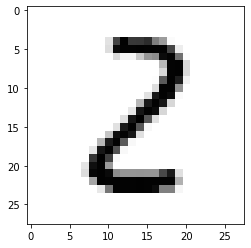

In [25]:
plt.imshow(mnist.test.images[r:r + 1].
          reshape(28, 28), cmap='Greys', interpolation='nearest')
plt.show()